In [1]:
import pystan
import arviz as ar
import numpy as np
import pandas as pd
from pathlib import Path
import random as r


def generate_model():
    # path definition for dataset
    path = Path("/Users/jacob/Esri/Besag-York-Mollie/datasets/mod-starbucks.csv")
    df = pd.read_csv(path,
                     usecols=["latitude", "longitude"])  # defining specific columns for spatial points, size, and edges
    N = len(df.values)  # size of actual csv file
    K = 2  # total number of data entries
    scaling_factor = 2.0  # factor of two for variance consistency
    node1 = []
    node2 = []
    y1 = []  # number of variables involved (coordinates) ranging from 1-2 in random sequences
    for i in range(N):
        rand = r.randint(1, 2)
        y1.append(rand)
        node1.append(rand)
        node2.append(rand)
    design_matrix = []
    for val in df.values:
        design_matrix.append([val[0], val[1]])
    edges = len(design_matrix)  # arbitrary number of edges

    # stan code block for the data and parameters
    stan_code = """
    functions {
        real icar_normal_lpdf(vector phi, int N, int[] node1, int[] node2){
            return -0.5 * dot_self(phi[node1] - phi[node2]) + normal_lpdf(sum(phi) | 0, 0.001 * N);
        }
    }
        
    data {
        int<lower=0> N;
        int<lower=0> edges;
        int<lower=1, upper=N> node1[edges];
        int<lower=1, upper=N> node2[edges];
        real<lower=0> scaling_factor;
        int<lower=1> K;
        int<lower=0> y[N];
        matrix[N, K] x;
    }
        
    parameters {
        real beta0;
        vector[K] betas;
        real logit_rho;
        vector[N] phi;
        vector[N] theta;
        real<lower=0> sigma;
    }
        
    transformed parameters {
        real<lower=0, upper=1> rho = inv_logit(logit_rho);
        vector[N] convolved_re = sqrt(rho / scaling_factor) * phi + sqrt(1 - rho) * theta;
    }
        
    model {
        y ~ poisson_log(beta0 + x * betas + convolved_re * sigma);
        beta0 ~ normal(0, 1);
        betas ~ normal(0, 1);
        logit_rho ~ normal(0, 1);
        sigma ~ normal(0, 1);
        theta ~ normal(0, 1);
        phi ~ icar_normal_lpdf(N, node1, node2);
    }
    """

    # model data initialization

    bym_data = {
        'N': N,  # size of the graph = number of values in csv
        'edges': edges,  # edge sets representing relations
        'node1': node1,  # set of indices corresponding to 1st component(i) of ICAR
        'node2': node2,  # set of indices corresponding to 2nd component(j) of ICAR
        'scaling_factor': scaling_factor,  # variance between spatial points
        'K': K,  # number of covariates
        'y': y1,  # number of outcomes
        'x': np.array(design_matrix)  # matrix for design of the structure of graph
    }

    # Utilize pystan package to allow the built-in StanModel class to fully generate a model and arviz to plot
    sm = pystan.StanModel(model_code=stan_code)
    fit = sm.sampling(data=bym_data, iter=1000, chains=4)
    ar.plot_density(fit, var_names=['beta0', 'betas', 'logit_rho', 'sigma', 'theta'])



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_54f7fb3cf4b6fd78375396106184c1dd NOW.


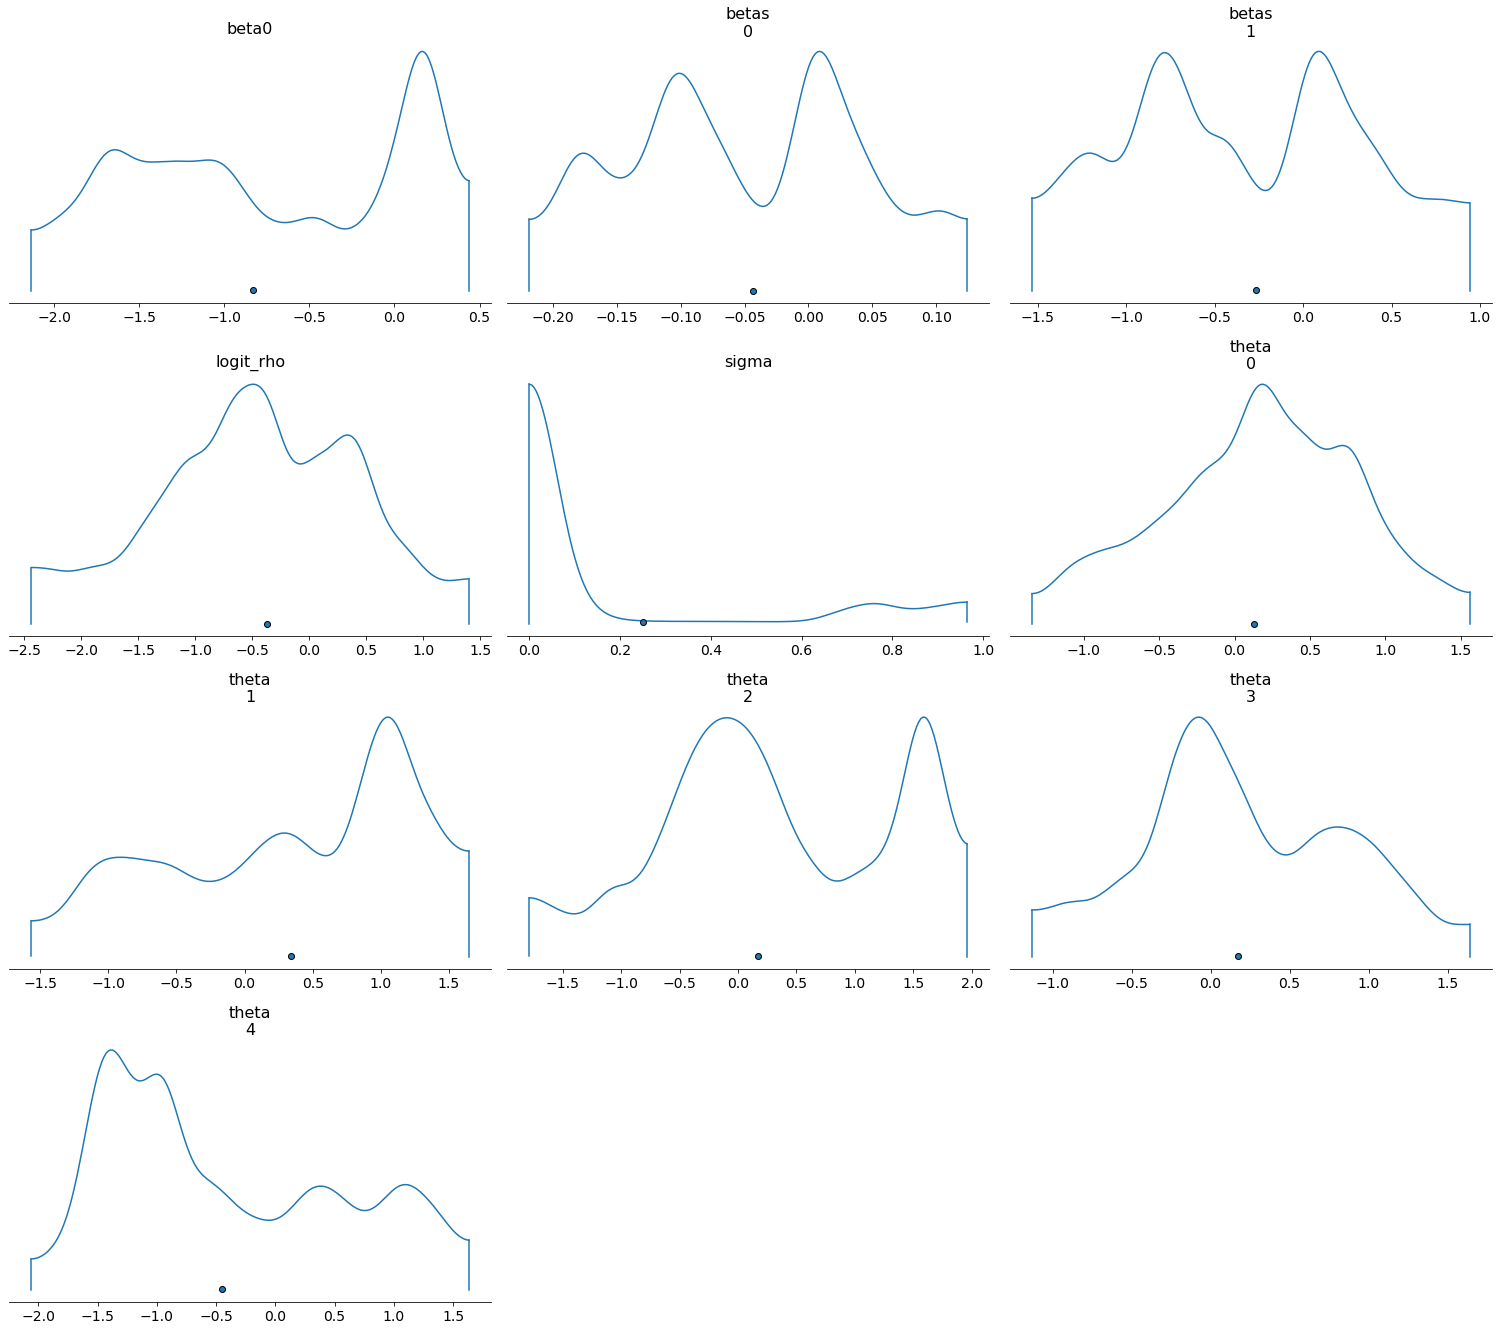

In [2]:
generate_model()